<a href="https://colab.research.google.com/github/kabirwalia8300/COVID19_Timeseries/blob/master/%CE%B2_estimationSIR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying time-dependent β in the SIR model using difference equations

### Imports

In [0]:
import pandas as pd
import numpy as np

#scipy
from scipy import stats as sps
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from datetime import timedelta, datetime

#visualizations
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

### Getting India's statewise data from Kaggle

In [0]:
# source: https://www.kaggle.com/sudalairajkumar/covid19-in-india
india = pd.read_csv("covid_19_india.csv", usecols=['Date', 'State/UnionTerritory', 'Cured', 'Deaths', 'Confirmed'])
india.tail()

,Date,State/UnionTerritory,Cured,Deaths,Confirmed
1313,25/04/20,Telengana,253,26,984
1314,25/04/20,Tripura,1,0,2
1315,25/04/20,Uttarakhand,25,0,48
1316,25/04/20,Uttar Pradesh,248,26,1778
1317,25/04/20,West Bengal,103,18,571


Cured, Deaths and Confirmed data is cumulative

In [0]:
def getCleanedStateData(state, df):
    df = df.loc[df['State/UnionTerritory']==state]
    return df


# State: Maharashtra

In [0]:
state = getCleanedStateData('Maharashtra', india)
# state['Date'] = pd.to_datetime(state['Date'])
state = state.set_index('Date')
state.head()

,State/UnionTerritory,Cured,Deaths,Confirmed
Date,,,,
09/03/20,Maharashtra,0,0,2
10/03/20,Maharashtra,0,0,5
11/03/20,Maharashtra,0,0,2
12/03/20,Maharashtra,0,0,11
13/03/20,Maharashtra,0,0,14


Function deltaInfected gives you the number infections that occur on a given day. Calculated by using data of the cumulative confirmations of the next day - cumulative confirmations of the current day.

In [0]:
def deltaInfected(df, col_name):
    deltas = []
    deltas.append(df[col_name][0])
    for x in range(1,len(df)):
        deltas.append(df[col_name][x] - df[col_name][x-1])
    del deltas[0]
    deltas.append(7628-6817) #checked that April 26 count is 7628
    df['deltaInfected'] = deltas
    return df
# deltaInfected(state, 'Confirmed')

In [0]:
state = deltaInfected(state, 'Confirmed')
state.head()

,State/UnionTerritory,Cured,Deaths,Confirmed,deltaInfected
Date,,,,,
09/03/20,Maharashtra,0,0,2,3
10/03/20,Maharashtra,0,0,5,-3
11/03/20,Maharashtra,0,0,2,9
12/03/20,Maharashtra,0,0,11,3
13/03/20,Maharashtra,0,0,14,0


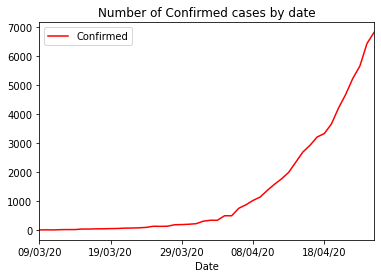

In [0]:
state.plot(y='Confirmed', color = 'red', title = "Number of Confirmed cases by date")

In [0]:
state['Days'] = range(len(state))
state.tail()

,State/UnionTerritory,Cured,Deaths,Confirmed,deltaInfected,Days
Date,,,,,,
21/04/20,Maharashtra,572,232,4669,552,43
22/04/20,Maharashtra,722,251,5221,431,44
23/04/20,Maharashtra,789,269,5652,778,45
24/04/20,Maharashtra,840,283,6430,387,46
25/04/20,Maharashtra,957,301,6817,811,47


In [0]:
#announced on 24th march so we assume effects start from 25th
lockdown_announce = '24/03/20'
lockdown_start = '25/03/20' 

preLockdown = state[:lockdown_announce]
postLockdown = state[lockdown_start:]
preLockdown

,State/UnionTerritory,Cured,Deaths,Confirmed,deltaInfected,Days
Date,,,,,,
09/03/20,Maharashtra,0,0,2,3,0
10/03/20,Maharashtra,0,0,5,-3,1
11/03/20,Maharashtra,0,0,2,9,2
12/03/20,Maharashtra,0,0,11,3,3
13/03/20,Maharashtra,0,0,14,0,4
14/03/20,Maharashtra,0,0,14,18,5
15/03/20,Maharashtra,0,0,32,0,6
16/03/20,Maharashtra,0,0,32,7,7
17/03/20,Maharashtra,0,1,39,3,8


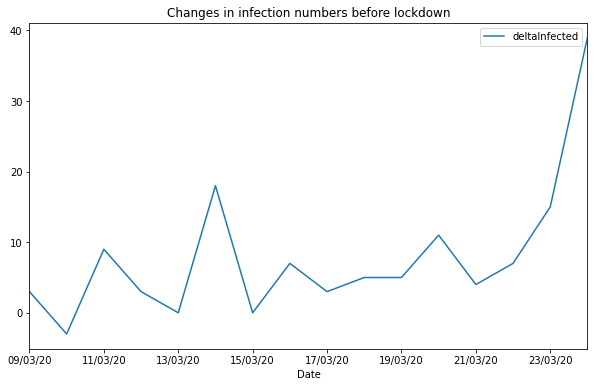

In [0]:
preLockdown.plot(y='deltaInfected', figsize=(10, 6), title = "Changes in infection numbers before lockdown")

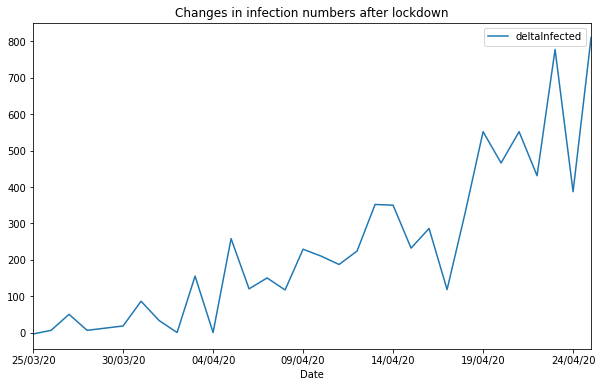

In [0]:
postLockdown.plot(y='deltaInfected', figsize=(10, 6), title = "Changes in infection numbers after lockdown")

In [0]:
# ALTERNATIVE CALCULATION
# def getBeta(state):
#     state['beta'] = (1/4) + (state['deltaInfected']/state['Confirmed'])
#     return state
# preLockdown = getBeta(preLockdown)
# postLockdown = getBeta(postLockdown)
# preAvg = preLockdown.sum(axis=0, skipna=True)['beta']/len(preLockdown)
# postAvg = postLockdown.sum(axis=0, skipna=True)['beta']/len(postLockdown)
# print(preAvg, postAvg)

####  Making a crucial assumption below. 
#### Considering that total number of susceptible people is large enough  such that it is comparable to the population of the state or of similar magnitude. 
#### This removes the dS/n term from the equation

In [0]:
def deltaInfected_SIR(Confirmed, beta):
    gamma = 1/14 # keep this constant; could try to optimize this as well
    dI = beta*Confirmed - gamma*Confirmed
    return dI

In [0]:
optParams, covMatrix = curve_fit(deltaInfected_SIR, preLockdown['Confirmed'], preLockdown['deltaInfected'], maxfev=5000)
preBeta = optParams

print("Prelockdown beta is {}".format(preBeta))

Prelockdown beta is [0.28443436]


In [0]:
optParams2, covMatrix2 = curve_fit(deltaInfected_SIR, postLockdown['Confirmed'], postLockdown['deltaInfected'], maxfev=5000)
postBeta = optParams2

print("Postlockdown beta is {}".format(postBeta))

Postlockdown beta is [0.1776951]


## Clearly shows a drop in the value of β.

Now we compare to the preLockdown numbers.

In [0]:
# this gives the new deltas in infected numbers
y_fitted = deltaInfected_SIR(preLockdown['Confirmed'], preBeta)

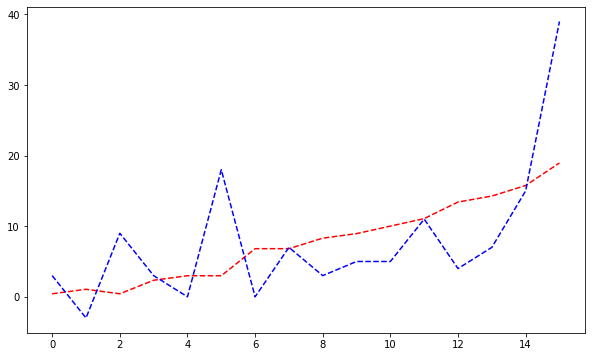

In [0]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(preLockdown['Days'], y_fitted, '--', label='fitted', color = 'r')
ax.plot(preLockdown['Days'], preLockdown['deltaInfected'], '--', label='Confirmed Data', color = 'b')

We now calculate the confirmations based on the general beta before the lockdown

In [0]:
newConfirmed = []
sum = 0
for x in y_fitted:
    sum = sum + x
    newConfirmed.append(sum)

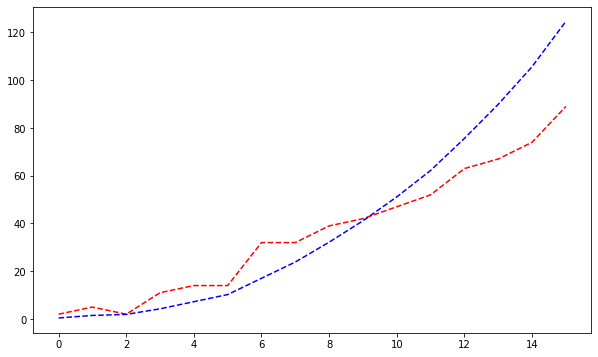

In [0]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(preLockdown['Days'], preLockdown['Confirmed'], '--', label='fitted', color = 'r')
ax.plot(preLockdown['Days'], newConfirmed, '--', label='Confirmed Data', color = 'b')

The difference at the end of 15 days here is not an error. 

In [0]:
postLockdown.head()

,State/UnionTerritory,Cured,Deaths,Confirmed,deltaInfected,Days
Date,,,,,,
25/03/20,Maharashtra,1,3,128,-4,16
26/03/20,Maharashtra,1,3,124,6,17
27/03/20,Maharashtra,15,4,130,50,18
28/03/20,Maharashtra,25,5,180,6,19
29/03/20,Maharashtra,25,6,186,12,20


## We now see predictions in the number of Confirmed cases and the Delta in infections had the β remained the same i.e. no lockdown was imposed.

In [0]:
postDay1_Confirm = np.sum(y_fitted)
def predictionsPost(beta, length, postDay1_Confirm):
    gamma = 1/14
    newDeltas = []
    newConfirms = []
    newConfirms.append(postDay1_Confirm)
    for x in range(length):
        dI = beta*newConfirms[x] - gamma*newConfirms[x]
        newDeltas.append(dI)
        newConfirms.append(newConfirms[x]+dI)
    return newConfirms, newDeltas

In [0]:
predicted_Confirms, predicted_Deltas = predictionsPost(preBeta, len(postLockdown), postDay1_Confirm)

In [0]:
preds= []
preds.append(predicted_Confirms[0])
for x in range(1,len(predicted_Confirms)):
    val = predicted_Confirms[x][0]
    preds.append(val)
del preds[-1]
# preds

In [0]:
delts = []
for x in range(0,len(predicted_Deltas)):
    val = predicted_Deltas[x][0]
    delts.append(val)
# delts

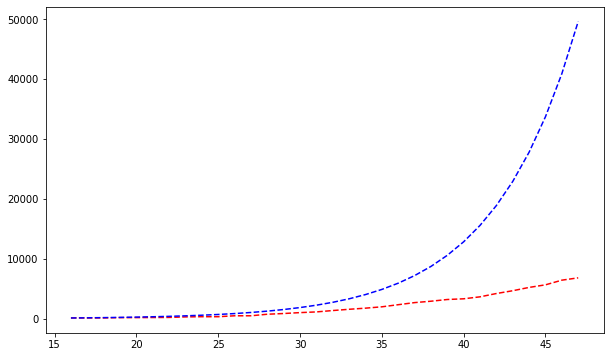

In [0]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(postLockdown['Days'], postLockdown['Confirmed'], '--', label='fitted', color = 'r')
ax.plot(postLockdown['Days'], preds, '--', label='Confirmed Data', color = 'b')
# x axis is simply days after March 9

### The above shows that without a lockdown (blue), the number of confirmed cases would rise exponentially.